In [5]:
#导入需要的库
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys 
import d2lzh_pytorch as d2l

In [6]:
print(torch.__version__)
#torch.set_default_tensor_type(torch.FloatTensor)在2.1和更高的版本中弃用


2.8.0+cu126


In [7]:
#读取数据，使用pandas来读取
train_data = pd.read_csv('./data/kaggle_house/train.csv')
test_data = pd.read_csv('./data/kaggle_house/test.csv')

In [8]:
#看一下数据的类型
train_data.shape#有1460个样本，80个特征，一个标签

(1460, 81)

In [9]:
test_data.shape#测试机有1459个样本和80个特征，需要吧测试数据集的每个样本标签预测出来

(1459, 80)

In [10]:
#查看前四个样本的前四个特征，后两个特征和标签
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


可以看到第一个特征是id，可以帮助模型记住每个训练样本，但是难以推广到测试样本，所以id不进入训练，所以要把训练数据和测试数据按后面的79个特征连结

In [11]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:-1]))
#这里将训练集和测试机的特定纵向拼接成一个新的dataframe，虽然train的-1列是label，但是按列拼接后就只剩features了
all_features.shape#纵向拼接，只剩79个features（因为test无label

(2919, 79)

In [12]:
#进行数据预处理
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
#得到特征中是数值类型（int，float）的index、
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))
#上面是对数据类型为数值的特征进行标准化（标准化就是-mean再/std
#标准化后，每个数值特征的均值就变成了零，所以对于缺失值，可以直接赋为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [13]:
#将离散数值转为指示特征，假设特征MSZoning里面有两个不同的离散值RL和RM，那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。如果一个样本原来在MSZoning里的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0。
all_features = pd.get_dummies(all_features,dummy_na = True)
all_features.shape#进行特征的处理后

(2919, 331)

In [103]:
#类型转换
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float)
#通过..values将dataframe转成numpy，然后再转成tensor
test_features = torch.tensor(all_features[n_train:].values,dtype = torch.float)
#得到labels
train_labels = torch.tensor(train_data.SalePrice.values,dtype = torch.float).view(-1,1)
#这里train_labels转成1460，1的shape,第一维是样本数量，第二维是label
#考虑后续能不能对labels进行归一化

In [117]:
#这里使用一个基本的线性回归模型和平方损失函数来训练模型
loss = torch.nn.MSELoss()
def get_net(feature_num):
    net = nn.Sequential(
        nn.Linear(feature_num,10),
        nn.ReLU(),
        nn.Linear(10,1))
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std= 0.01)
    return net

In [118]:
#定义均方根误差
def log_rmse(net,features,labels):
    with torch.no_grad():
        clipped_preds = torch.max(net(features),torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(),labels.log()))
        return rmse.item()
        

In [119]:
# 定义训练函数
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls=[],[]
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle = True)
    #使用adam优化算法
    optimizer = torch.optim.Adam(params = net.parameters(),lr = learning_rate,weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls
        

In [120]:
#k折交叉验证（用来选择模型设计和调节超参数，下面的函数用来返回第i折交叉验证时所需要的训练和验证数据
def get_k_fold_data(k,i,X,y):#返回第i折交叉验证时所需要的训练和验证数据
    assert k>1
    fold_size = X.shape[0]//k#计算每折的大小
    X_train,y_train = None,None
    for j in range(k):#遍历每一折
        idx = slice(j*fold_size,(j+1)*fold_size)#计算当前折的索引范围
        X_part,y_part = X[idx,:],y[idx]#提取当前折的数据
        if j==i:#如果是第i折，就作为验证机
            X_valid,y_valid = X_part,y_part
        elif X_train is None:#如果是第一折，做训练数据
            X_train,y_train = X_part,y_part

        else:#其他折纵向拼接到训练数据下面
            X_train = torch.cat((X_train,X_part),dim=0)
            y_train = torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_valid,y_valid

In [121]:
#在k折交叉验证中我们训练k次，并返回训练和验证的平均误差
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum = 0
    valid_l_sum = 0
    for i in range(k):
        data = get_k_fold_data(k,i,X_train,y_train)#得到数据
        net = get_net(X_train.shape[1])#这里x——train是三维数据，第二维是batch
        train_ls,valid_ls = train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum+= train_ls[-1]#累加每次训练的loss
        valid_l_sum+= valid_ls[-1]#累加每次验证的loss
        if i==0:
            d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse',
                         range(1,num_epochs+1),valid_ls,['train','valid'])
        print("fold %d, trian rmse %f,valid rmse %f" % (i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k#得到训练集和验证集 的平均loss作为这一轮的loss
        

fold 0, trian rmse 0.082110,valid rmse 0.147630
fold 1, trian rmse 0.084072,valid rmse 0.142772
fold 2, trian rmse 0.106852,valid rmse 0.155845
fold 3, trian rmse 0.072284,valid rmse 0.185436
fold 4, trian rmse 0.341561,valid rmse 0.167210
fold 5, trian rmse 0.111063,valid rmse 0.174543
fold 6, trian rmse 0.088736,valid rmse 0.152164
fold 7, trian rmse 0.077362,valid rmse 0.138183
fold 9, trian rmse 0.079358,valid rmse 0.144947
10-fold validation:avg train rmse 0.112557,avg valid rmse 0.160709


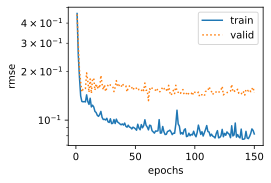

In [122]:
#这里设置超参数，之后有改动
k,num_epochs,lr,weight_decay,batch_size = 10,150,5,3,128
train_l ,valid_l = k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation:avg train rmse %f,avg valid rmse %f' % (k,train_l,valid_l))

In [ ]:
#定义预测函数
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    net = get_net(train_features.shape[1])
    train_ls,_ = train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('./subssion.csv',index=False)

train rmse 0.086989


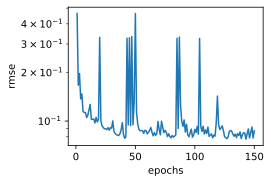

In [ ]:
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)

0
1
